# Data Cleaning and Feature Engineering for Data Science Job Listings


*Franco Pérez Rivera - Data Portfolio Project*

This notebook performs comprehensive data cleaning and feature engineering on Glassdoor job listings, with a focus on extracting relevant features for salary prediction and job categorization. The goal is to prepare the dataset for exploratory analysis and machine learning modeling.


## 0: Executive Summary

This exploratory data analysis (EDA) investigates salary trends across the United States for data-related roles, using job listings and cost of living estimates. The goal was to identify key factors that influence average salary and evaluate how far salaries go in different regions.

### 🔍 Key steps and insights:
- Cleaned and transformed variables, grouping sparse categories to improve statistical significance and interpretability.
- Identified important predictors such as job category, industry, company revenue, and region.
- Analyzed tool prevalence by job category, keeping only statistically meaningful technologies.
- Combined salary data with cost of living estimates to calculate where salaries stretch further across the U.S.

The analysis was conducted in Python using libraries like **pandas**, **seaborn**, **matplotlib**, and **scikit-learn**.


## 1. Imports and datasets

In [1]:
# Auto-reload for development (optional)
%load_ext autoreload
%autoreload 2

# Core libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

# Custom functions
import FunctionsCleaning as f


In [2]:
# Load dataset
df_raw = pd.read_csv('C:\\Users\\frano\\Desktop\\Practica DA\\US Salary Project\\Data\\glassdoor_jobs.csv')

# Display basic info
print(f"Dataset shape: {df_raw.shape}")
df_raw.head(3)


Dataset shape: (956, 15)


,Unnamed: 0,Job Title,Salary Estimate,Job Description,Rating,Company Name,Location,Headquarters,Size,Founded,Type of ownership,Industry,Sector,Revenue,Competitors
0,0,Data Scientist,$53K-$91K (Glassdoor est.),"Data Scientist\nLocation: Albuquerque, NM\nEdu...",3.8,Tecolote Research\n3.8,"Albuquerque, NM","Goleta, CA",501 to 1000 employees,1973,Company - Private,Aerospace & Defense,Aerospace & Defense,$50 to $100 million (USD),-1
1,1,Healthcare Data Scientist,$63K-$112K (Glassdoor est.),What You Will Do:\n\nI. General Summary\n\nThe...,3.4,University of Maryland Medical System\n3.4,"Linthicum, MD","Baltimore, MD",10000+ employees,1984,Other Organization,Health Care Services & Hospitals,Health Care,$2 to $5 billion (USD),-1
2,2,Data Scientist,$80K-$90K (Glassdoor est.),"KnowBe4, Inc. is a high growth information sec...",4.8,KnowBe4\n4.8,"Clearwater, FL","Clearwater, FL",501 to 1000 employees,2010,Company - Private,Security Services,Business Services,$100 to $500 million (USD),-1


##  2. Basis data Cleaning

### a. Drop Unwanted Columns


The `Unnamed: 0` column is an index column that is not needed.

In [3]:
df_raw.drop(columns=["Unnamed: 0"], inplace=True)

### b. Basic Data Quality Checks



As a first step in the data cleaning pipeline, we defined a helper function `basic_data_checks()` to run essential quality checks:

- **Missing values:** Displays the total number of missing values and identifies the columns affected.

- **Duplicate rows:** Detects duplicated rows and optionally removes them based on the remove_duplicates parameter.

- **Constant columns:** Flags columns that contain only one unique value, which are typically non-informative.

- **DataFrame overview:** Prints the shape of the dataset and the data types of each column.

This function ensures that the dataset is structurally sound before applying any transformations or feature engineering.

To maintain flexibility across analysis and modeling phases, we create three versions of the dataset at this point:

1. `df_analysis:` For exploratory data analysis (EDA), we remove duplicate rows to avoid inflating statistics like averages or frequencies.

2. `df_modeling_tree`: For tree-based models such as Random Forest, we keep duplicate rows, as these models can benefit from repeated patterns to reinforce learning.

3. `df_modeling_linear`: For linear or regularized models (e.g., Linear Regression, Lasso), we create a version where each unique observation is retained once, and a **weight** column is added to reflect how many times it appears in the full dataset. This allows us to preserve the statistical strength of repeated rows without duplicating them, by passing the weights to the model using the **sample_weight** parameter.

This multi-DataFrame setup allows us to balance statistical rigor in EDA with modeling performance and flexibility in downstream tasks.

In [4]:
# Base DataFrame for tree-based modeling: keep all duplicates
df_modeling_tree = df_raw.copy()

# EDA version: remove duplicate rows to avoid skewing statistics
df_analysis = f.basic_data_checks(df_raw.copy(), remove_duplicates=True)

# Linear modeling version: compute weights based on full dataset
df_modeling_linear = df_modeling_tree.copy()

# Count how many times each full row (including target) appears
df_modeling_linear['weight'] = df_modeling_linear.groupby(
    df_modeling_linear.columns.tolist()
)[df_modeling_linear.columns[0]].transform('count')

# Drop duplicates to keep only one row per group
df_modeling_linear = df_modeling_linear.drop_duplicates()

# Display shapes and weight distribution
print("📦 df_modeling_linear with weights:", df_modeling_linear.shape)
print(df_modeling_linear['weight'].value_counts().sort_index())

print("✅ DataFrames ready:")
print("df_analysis:", df_analysis.shape)
print("df_modeling_tree:", df_modeling_tree.shape)
print("df_modeling_linear:", df_modeling_linear.shape)
    

📐 Initial DataFrame shape: (956, 14)
✅ No missing values found.
⚠️ Found 356 duplicate rows.
🧹 Duplicates removed.
📏 New shape: (600, 14)

🔍 Data types:
Job Title             object
Salary Estimate       object
Job Description       object
Rating               float64
Company Name          object
Location              object
Headquarters          object
Size                  object
Founded                int64
Type of ownership     object
Industry              object
Sector                object
Revenue               object
Competitors           object
dtype: object
📦 df_modeling_linear with weights: (600, 15)
weight
1    322
2    213
3     52
4     13
Name: count, dtype: int64
✅ DataFrames ready:
df_analysis: (600, 14)
df_modeling_tree: (956, 14)
df_modeling_linear: (600, 15)


In [5]:
all_dfs = [df_analysis, df_modeling_tree, df_modeling_linear]

## 3. Feature Engineering

### a. Job Title Categorization

To simplify and analyze job roles effectively, we categorized job titles into broad, standardized groups. This step helps reduce the dimensionality of the `Job Title` feature and makes it easier to compare roles and predict salary ranges.

We used a custom function, `title_simplifier`, which applies regular expressions to classify titles into the following categories:

- **data scientist**
- **data engineer**
- **data analyst**
- **scientist**
- **analyst**
- **mle** (Machine Learning Engineer)
- **na** (Not Applicable / Unclassified)

This categorization ensures consistency and allows for better grouping of similar job roles.

In [6]:
for df in all_dfs:
    df["Job Category"] = df["Job Title"].apply(f.title_simplifier)


In [7]:
df_analysis["Job Category"].value_counts()

Job Category
data scientist    265
scientist         100
data engineer      94
data analyst       78
na                 42
mle                21
Name: count, dtype: int64

Lets look at those na values to see if we miss anything

In [8]:
df[df["Job Category"] == "na"]['Job Title'].value_counts().sort_values(ascending=False).head(5)

Job Title
Business Intelligence Analyst      9
Analytics Manager                  2
Data Management Specialist         1
Data Modeler                       1
BI & Platform Analytics Manager    1
Name: count, dtype: int64

All of these titles do not fit into any predefined category, or the number of occurrences is too low (fewer than 5) to warrant a separate category (e.g., Clinical Data or Data Modeler). We will retain them for now, but they may be removed in later stages of the analysis.

### b. Extracting Required Years of Experience

#### 1. Extract experience

Many job listings specify the required years of experience within the job description. Extracting this numeric information helps assess the seniority level required and its correlation with salary.

We developed a custom function, `extract_experience`, which uses regular expressions to detect phrases like:
- "3+ years of experience"
- "2-4 years of experience"
- "5 years experience"

The function returns both:
- A numeric value (average if a range is found)
- The exact matched phrase for validation

To ensure data quality, we also flagged and reviewed potential outliers (e.g., 45 or 80 years), which were corrected or excluded. This step ensures that the extracted experience data is reliable and consistent.

⚠️ Potential outlier: 80 years | Phrase: '80 years of experience'
⚠️ Potential outlier: 45 years | Phrase: '45 years of experience'
⚠️ Potential outlier: 80 years | Phrase: '80 years of experience'
⚠️ Potential outlier: 80 years | Phrase: '80 years of experience'
⚠️ Potential outlier: 45 years | Phrase: '45 years of experience'
⚠️ Potential outlier: 80 years | Phrase: '80 years of experience'
⚠️ Potential outlier: 45 years | Phrase: '45 years of experience'
(142,)


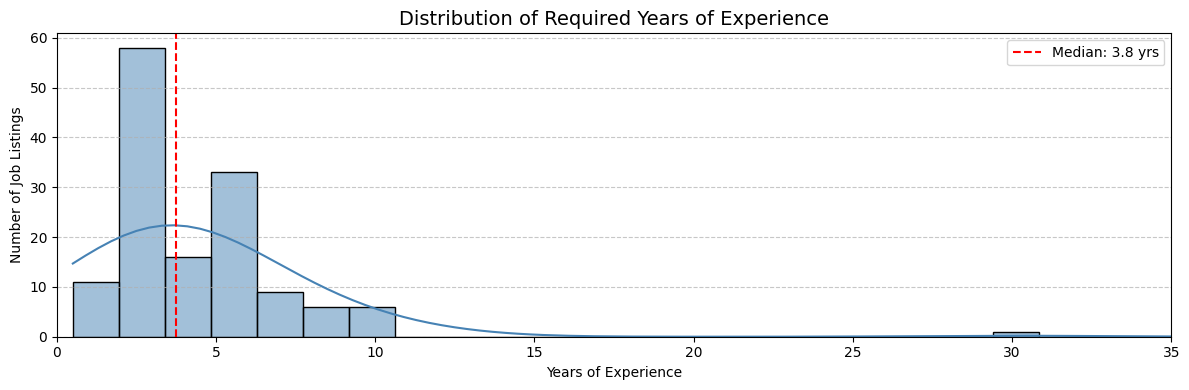

In [9]:
# Apply the function to extract years of experience and the matched phrase
for df in all_dfs:
    df[["Years of Experience", "Experience Extract"]] = df["Job Description"].apply(
        lambda x: pd.Series(f.extract_experience(x))
    )

# Display value counts of extracted experience
df_analysis["Years of Experience"].value_counts().sort_index()

# Drop NaN values for plotting
experience_data = df_analysis["Years of Experience"].dropna()
print(experience_data.shape)

# Calculate median
median_experience = experience_data.median()

# Plot
plt.figure(figsize=(12, 4))
sns.histplot(experience_data, bins=55, kde=True, color="steelblue", edgecolor="black")
plt.axvline(median_experience, color="red", linestyle="--", label=f"Median: {median_experience:.1f} yrs")
plt.title("Distribution of Required Years of Experience", fontsize=14)
plt.xlabel("Years of Experience")
plt.ylabel("Number of Job Listings")
plt.xlim(0, 35)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()


##### Distribution of Required Experience

The histogram below shows the distribution of years of experience required across job listings. Most roles require between 2 and 5 years of experience, while a few listings contain irregular values that were handled manually.
It might be interesting to look in the description the year of experience required for each role

#### 2. Correcting Outliers in Experience Extraction


During experience extraction, some job descriptions returned unrealistic values (e.g., 45 or 80 years of experience), likely due to incorrect pattern matching.

To address this, we manually reviewed the affected rows and removed the misleading phrases from the job descriptions. We then re-applied the `extract_experience` function to recalculate the correct values.

The helper function `remove_and_recalculate_experience` automates this process for specified rows, ensuring that outliers are handled cleanly and consistently.


In [10]:
print(df_analysis[df_analysis["Years of Experience"].isin([45, 30, 80])]['Experience Extract'].value_counts())


Experience Extract
80 years of experience    1
30 years of experience    1
45 years of experience    1
Name: count, dtype: int64


In [11]:
df_analysis.shape

(600, 17)

In [12]:
# List of row indices with incorrect experience values
for df in all_dfs:
    incorrect_indices = df[df["Years of Experience"].isin([45, 80, 30])].index.tolist()

    # Apply correction
    df_corrected = f.remove_and_recalculate_experience(df, incorrect_indices)

    # View corrected rows
    df_corrections = df_corrected.loc[incorrect_indices, ["Job Description", "Experience Extract", "Years of Experience"]]
    print("Corrected Experience Values:")
    display(df_corrections)

    df = df_corrected.copy()


Corrected Experience Values:


,Job Description,Experience Extract,Years of Experience
226,Are you interested in a career opportunity wit...,NaN,NaN
519,Data Analyst Senior\nLocation\n\n\nPhiladelphi...,5 years of experience,5.0
788,Are you ready to explore a world of possibilit...,NaN,NaN


Corrected Experience Values:


,Job Description,Experience Extract,Years of Experience
226,Are you interested in a career opportunity wit...,NaN,NaN
386,Are you interested in a career opportunity wit...,NaN,NaN
519,Data Analyst Senior\nLocation\n\n\nPhiladelphi...,5 years of experience,5.0
779,Data Analyst Senior\nLocation\n\n\nPhiladelphi...,5 years of experience,5.0
788,Are you ready to explore a world of possibilit...,NaN,NaN


Corrected Experience Values:


,Job Description,Experience Extract,Years of Experience
226,Are you interested in a career opportunity wit...,NaN,NaN
519,Data Analyst Senior\nLocation\n\n\nPhiladelphi...,5 years of experience,5.0
788,Are you ready to explore a world of possibilit...,NaN,NaN


Now lets look again at the final values

(142,)


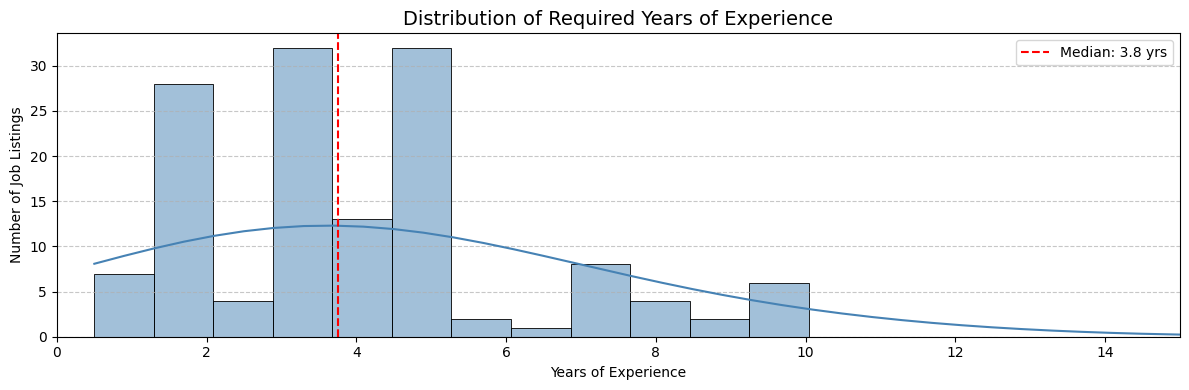

In [13]:

# Drop NaN values for plotting
experience_data = df_analysis["Years of Experience"].dropna()
print(experience_data.shape)
# Calculate median
median_experience = experience_data.median()

# Plot
plt.figure(figsize=(12, 4))
sns.histplot(experience_data, bins=100, kde=True, color="steelblue", edgecolor="black")
plt.axvline(median_experience, color="red", linestyle="--", label=f"Median: {median_experience:.1f} yrs")
plt.title("Distribution of Required Years of Experience", fontsize=14)
plt.xlabel("Years of Experience")
plt.ylabel("Number of Job Listings")
plt.xlim(0, 15)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()

#### 3. Extracting Broader Experience from Job Descriptions



For many job listings, a specific number of years of experience could not be extracted. However, these listings often include qualitative descriptions of experience, such as "strong experience" or "experience with SQL".

To capture this information, we implemented a two-step process:

1. **broader_experience_extraction**: This function searches for general phrases indicating experience, even when no specific number is provided. It uses regular expressions to identify patterns such as:
    - "strong experience"
    - "experience with SQL"
    - "background in AI"
    - "proven experience"

2. **categorize_broader_experience**: Once a relevant phrase is found, it is categorized into:
    - **Strong Experience**: e.g., "extensive experience", "proven experience"
    - **Some Experience**: e.g., "background in", "expertise in"
    - **General Experience**: e.g., "experience with", "hands-on experience"
    - **Unknown**: No relevant phrase found

This allows us to leverage non-numeric experience indicators and assign an experience level to listings that would otherwise remain unclassified.


In [14]:
# Filter rows with missing numeric experience
df_na_experience = df_analysis[df_analysis["Years of Experience"].isna()].copy()

# Extract broader experience phrases
df_na_experience["Broader Experience Extract"] = df_na_experience["Job Description"].apply(f.broader_experience_extraction)

# Categorize extracted phrases
df_na_experience["Experience Category"] = df_na_experience["Broader Experience Extract"].apply(f.categorize_broader_experience)

# View counts per category
df_na_experience["Experience Category"].value_counts()


Experience Category
Unknown               184
General Experience    139
Some Experience        90
Strong Experience      45
Name: count, dtype: int64

#### 4. Categorizing Experience Levels and Merging Categories

To simplify analysis, we grouped numeric years of experience into standardized experience levels:

- **Entry Level**: 0–2 years
- **Junior**: 3–5 years
- **Mid Level**: 6–9 years
- **Senior**: 10+ years
- **Unknown**: Missing or invalid data

After categorizing the numeric values, we merged these with the previously extracted qualitative experience categories from broader descriptions (e.g., "Strong Experience").

This allowed us to assign a consistent experience category to each job listing, even when numeric data was missing.

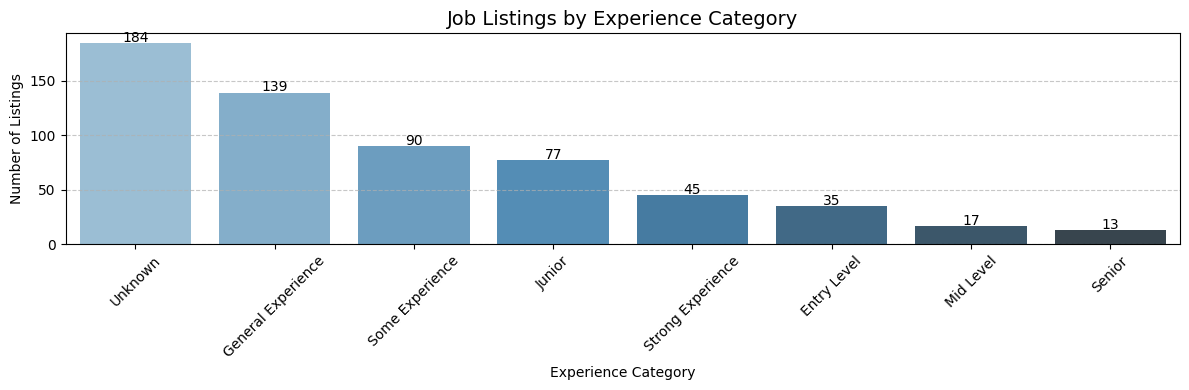

In [15]:
for df in all_dfs:
    # Categorize numeric experience
    df["Experience Level"] = df["Years of Experience"].apply(f.categorize_experience)

    # Default merged value
    df["Merged Experience Category"] = df["Experience Level"]

    # Merge qualitative experience where numeric is missing
    df.loc[df["Years of Experience"].isna(), "Merged Experience Category"] = df.loc[
        df["Years of Experience"].isna()
    ]["Job Description"].apply(
        lambda x: f.categorize_broader_experience(f.broader_experience_extraction(x))
    )
# View final counts

# Prepare data
exp_counts = df_analysis["Merged Experience Category"].value_counts().sort_values(ascending=False).reset_index()
exp_counts.columns = ["Experience Category", "Count"]

# Plot
plt.figure(figsize=(12, 4))
sns.barplot(
    data=exp_counts, 
    x="Experience Category", 
    y="Count", 
    hue="Experience Category", 
    palette="Blues_d", 
    legend=False
)

# Add number labels on bars
for index, row in exp_counts.iterrows():
    plt.text(x=index, y=row["Count"] + 1, s=int(row["Count"]), ha='center', fontsize=10)

plt.title("Job Listings by Experience Category", fontsize=14)
plt.xlabel("Experience Category")
plt.ylabel("Number of Listings")
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()


### c. Number of Competitors




The `Competitors` column provides a comma-separated list of competitor companies (if available). To quantify this information, we created a new feature called `num_comp`, which represents the number of competitors listed for each company.

If the value is "-1" (indicating missing data), we assign a value of 0.


In [16]:
# Create a feature for the number of listed competitors
for df in all_dfs:
    df["num_comp"] = df["Competitors"].apply(lambda x: len(x.split(',')) if isinstance(x, str) and x != "-1" else 0)


### d. Salary Estimate Cleaning and Parsing



The `Salary Estimate` column contains salary ranges in different formats. Some values represent hourly wages, while others include extra information like "(Glassdoor est.)" or "Employer provided salary".

We performed several steps to clean and standardize the salary information:

1. **Removed invalid entries**: We excluded rows where the estimate was "-1".
2. **Identified hourly salaries**: A new binary feature `is_hourly` was created to flag per-hour listings.
3. **Cleaned the text**: We removed symbols like "$", "K", and extra phrases to isolate the numeric salary range.
4. **Parsed salary ranges**: We extracted the minimum and maximum salary values and converted them to integers.
5. **Adjusted hourly salaries**: As an approximation, hourly salaries were doubled to estimate annual equivalents.
6. **Created `avg_salary`**: This feature represents the average of the min and max salary for each listing.


In [17]:
df_analysis, df_modeling_tree, df_modeling_linear = all_dfs  # unpack original versions

updated_dfs = []
for df in all_dfs:
    df = df[df["Salary Estimate"] != "-1"].copy()

    df["is_hourly"] = df["Salary Estimate"].apply(lambda x: 1 if "hour" in x.lower() else 0)

    salary_clean = df["Salary Estimate"].apply(lambda x: x.split("(")[0])
    salary_clean = salary_clean.str.replace("K", "", regex=False).str.replace("$", "", regex=False)
    salary_clean = salary_clean.str.lower().str.replace("per hour", "", regex=False).str.replace("employer provided salary:", "", regex=False)

    df["min_salary"] = salary_clean.apply(lambda x: int(x.split("-")[0]) if "-" in x else np.nan)
    df["max_salary"] = salary_clean.apply(lambda x: int(x.split("-")[1]) if "-" in x else np.nan)

    df["min_salary"] = np.where(df["is_hourly"] == 1, df["min_salary"] * 2, df["min_salary"])
    df["max_salary"] = np.where(df["is_hourly"] == 1, df["max_salary"] * 2, df["max_salary"])

    df["avg_salary"] = (df["min_salary"] + df["max_salary"]) / 2

    updated_dfs.append(df)

# Reassign to named variables
df_analysis, df_modeling_tree, df_modeling_linear = updated_dfs


#### Salary Distribution by Job Category




Below are two visualizations that help understand salary differences across job roles:

- The first chart shows the **average salary** per job category, with **standard deviation** as error bars.
- The second chart is a **boxplot**, providing a detailed view of salary distribution and outliers within each job category.

C:\Users\frano\AppData\Local\Temp\ipykernel_12176\1931079802.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


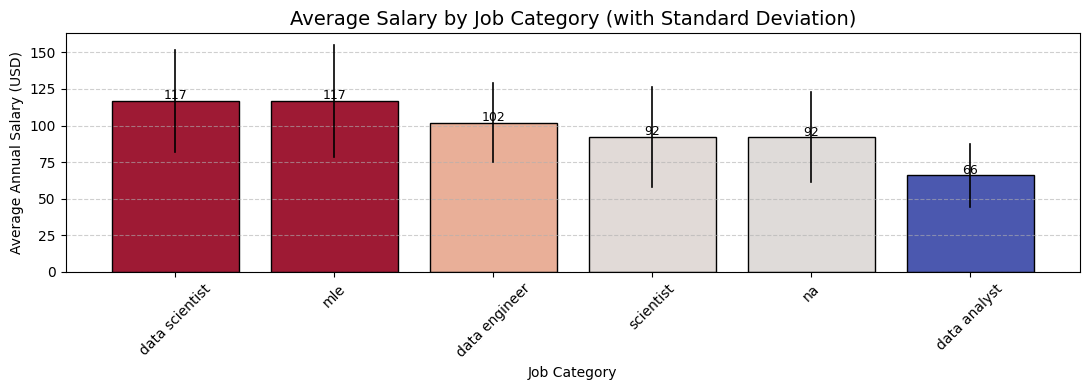

C:\Users\frano\AppData\Local\Temp\ipykernel_12176\1931079802.py:54: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


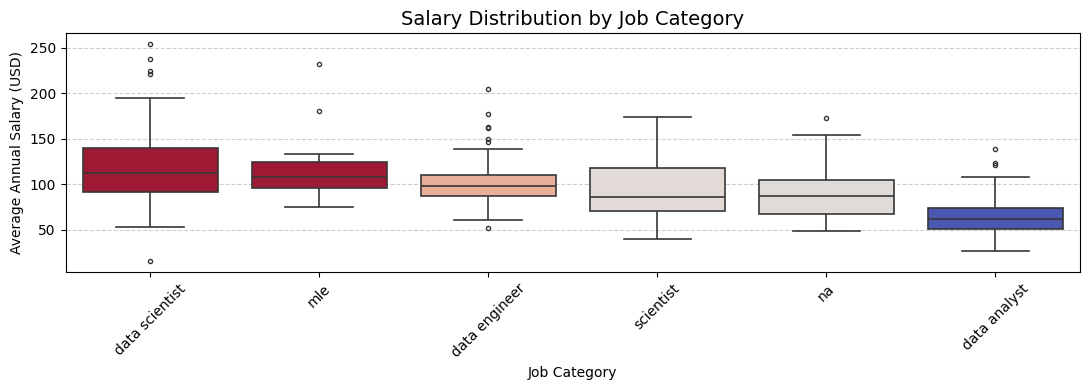

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Copy the working DataFrame
df_plot = df_analysis.copy()

# Filter out categories with low count to improve statistical reliability (optional)
category_counts = df_plot["Job Category"].value_counts()
min_count_threshold = 10
valid_categories = category_counts[category_counts >= min_count_threshold].index
df_plot = df_plot[df_plot["Job Category"].isin(valid_categories)]

# Group by category: mean + std
salary_stats = df_plot.groupby("Job Category")["avg_salary"].agg(["mean", "std", "count"]).sort_values(by="mean", ascending=False).reset_index()

# Color palette based on mean salary (automatically sorted)
norm = plt.Normalize(salary_stats["mean"].min(), salary_stats["mean"].max())
colors = plt.cm.coolwarm(norm(salary_stats["mean"]))
color_dict = dict(zip(salary_stats["Job Category"], colors))

# Barplot
plt.figure(figsize=(11, 4))
sns.barplot(
    data=salary_stats,
    x="Job Category",
    y="mean",
    palette=color_dict,
    edgecolor="black"
)

# Add value labels and standard deviation lines
for index, row in salary_stats.iterrows():
    plt.text(index, row["mean"] + 1, f"{row['mean']:.0f}", ha="center", fontsize=9)
    plt.plot([index, index], [row["mean"] - row["std"], row["mean"] + row["std"]], color="black", linewidth=1.2)

plt.title("Average Salary by Job Category (with Standard Deviation)", fontsize=14)
plt.xlabel("Job Category")
plt.ylabel("Average Annual Salary (USD)")
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

# Reorder Job Category based on mean salary for boxplot
df_plot["Job Category"] = pd.Categorical(
    df_plot["Job Category"],
    categories=salary_stats["Job Category"],
    ordered=True
)

# Boxplot
plt.figure(figsize=(11, 4))
sns.boxplot(
    data=df_plot,
    x="Job Category",
    y="avg_salary",
    palette=color_dict,
    fliersize=3,
    linewidth=1.2
)

plt.title("Salary Distribution by Job Category", fontsize=14)
plt.xlabel("Job Category")
plt.ylabel("Average Annual Salary (USD)")
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()


### e. Company Information

We engineered several features from company-related fields to enrich our dataset:

1. **Company Name Cleaned (`company_txt`)**:  
   Some entries in `Company Name` include the company's rating (e.g., `"Company Name\n3.8"`). We created a cleaned version by removing the rating when present.

2. **Job State (`job_state`)**:  
   We extracted the state from the `Location` field, which contains a `"City, State"` format.

4. **Company Age (`age`)**:  
   Calculated as the difference between the current year and the company's founding year. For values less than 1 or missing, the original value is retained.

In [19]:
df_analysis.columns

Index(['Job Title', 'Salary Estimate', 'Job Description', 'Rating',
       'Company Name', 'Location', 'Headquarters', 'Size', 'Founded',
       'Type of ownership', 'Industry', 'Sector', 'Revenue', 'Competitors',
       'Job Category', 'Years of Experience', 'Experience Extract',
       'Experience Level', 'Merged Experience Category', 'num_comp',
       'is_hourly', 'min_salary', 'max_salary', 'avg_salary'],
      dtype='object')

In [20]:
from datetime import date

updated_dfs = []
current_year = date.today().year

# ✅ Make sure you're looping over the latest version
all_dfs = [df_analysis, df_modeling_tree, df_modeling_linear]

for df in all_dfs:
    df = df.copy()

    # Add company info columns
    df["company_txt"] = df.apply(
        lambda x: x["Company Name"] if x["Rating"] < 0 else x["Company Name"][:-4], axis=1
    )

    df["job_state"] = df["Location"].apply(
        lambda x: x.split(",")[1].strip() if isinstance(x, str) and "," in x else "Unknown"
    )

    df["age"] = df["Founded"].apply(
        lambda x: x if x < 1 else current_year - x
    )

    updated_dfs.append(df)

# Reassign final DataFrames
df_analysis, df_modeling_tree, df_modeling_linear = updated_dfs


### f. Extracting Tools and Technologies from Job Descriptions


To better understand the technical requirements for data-related roles, we extracted the presence of specific tools and technologies mentioned in the `Job Description` field.

We defined a curated list of relevant keywords commonly expected in Data Analyst and Data Scientist positions, including:

- Programming languages (e.g., Python, R, SQL)
- BI tools (e.g., Excel, Tableau, Power BI)
- Machine learning libraries (e.g., TensorFlow, PyTorch, Scikit-learn)
- Cloud and DevOps tools (e.g., AWS, Docker, Kubernetes)

For each tool, we created a binary column indicating its presence (1) or absence (0) in the job description. We also handled special cases like detecting `"R"` as a standalone tool using a custom regular expression.

In [21]:
import re

# List of tools/skills to detect
important_tools = [
    "python", "r", "sql", "excel", "tableau", "power bi", "sas", "hadoop", "spark", 
    "tensorflow", "keras", "pytorch", "scikit-learn", "matplotlib", "snowflake", 
    "numpy", "pandas", "scipy", "bigquery", "aws", "azure", "google cloud", 
    "airflow", "git", "docker", "kubernetes"
]

# Function to detect standalone "R"

def detect_r(text):
    if isinstance(text, str):
        return 1 if re.search(r'\bR\b', text, re.IGNORECASE) else 0
    return 0

# Regenerar columnas *_yn
updated_dfs = []
for df in [df_analysis, df_modeling_tree, df_modeling_linear]:
    df = df.copy()

    for tool in important_tools:
        if tool != "r":
            col_name = f"{tool}_yn"
            df[col_name] = df["Job Description"].apply(
                lambda x: 1 if isinstance(x, str) and tool in x.lower() else 0
            )

    df["r_yn"] = df["Job Description"].apply(detect_r)
    df["Description_len"] = df["Job Description"].apply(lambda x: len(x) if isinstance(x, str) else 0)

    updated_dfs.append(df)

# Reasignar
df_analysis, df_modeling_tree, df_modeling_linear = updated_dfs


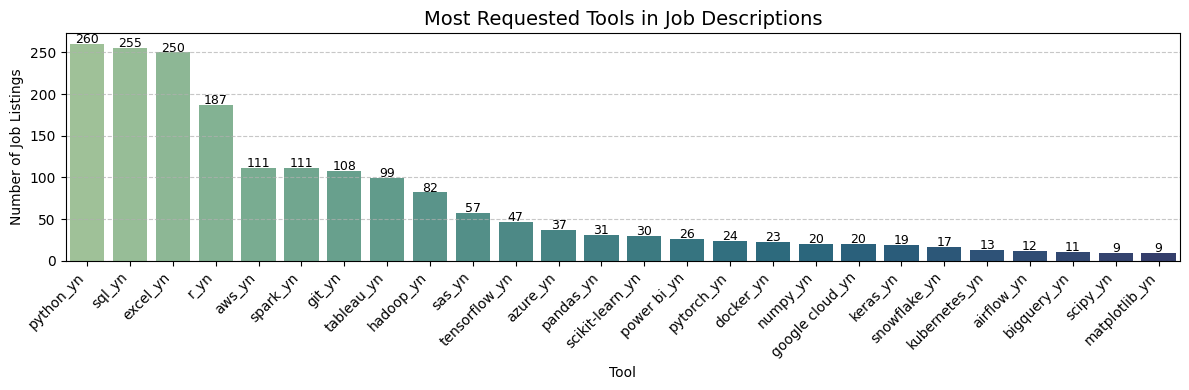

In [22]:
# Calculate frequency of each tool
tool_counts = df_analysis[[f"{tool}_yn" for tool in important_tools]].sum().sort_values(ascending=False).reset_index()
tool_counts.columns = ["Tool", "Count"]

# Plot
plt.figure(figsize=(12, 4))
sns.barplot(data=tool_counts, x="Tool", y="Count", hue="Tool", palette="crest")

# Add labels on top of bars
for index, row in tool_counts.iterrows():
    plt.text(index, row["Count"] + 1, int(row["Count"]), ha="center", fontsize=9)

plt.title("Most Requested Tools in Job Descriptions", fontsize=14)
plt.xlabel("Tool")
plt.ylabel("Number of Job Listings")
plt.xticks(rotation=45, ha="right")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()


In [23]:
# Get tool columns that exist in df_analysis
tool_cols = [f"{tool}_yn" for tool in important_tools if f"{tool}_yn" in df_analysis.columns]

# Calculate total mentions across all tools
total_mentions = df_analysis[tool_cols].values.sum()

# Count mentions per tool and sort descending
tool_counts = df_analysis[tool_cols].sum().sort_values(ascending=False).reset_index()
tool_counts.columns = ["Tool", "Count"]


C:\Users\frano\AppData\Local\Temp\ipykernel_12176\656341888.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=tool_counts, x="Tool", y="Count", palette=palette)


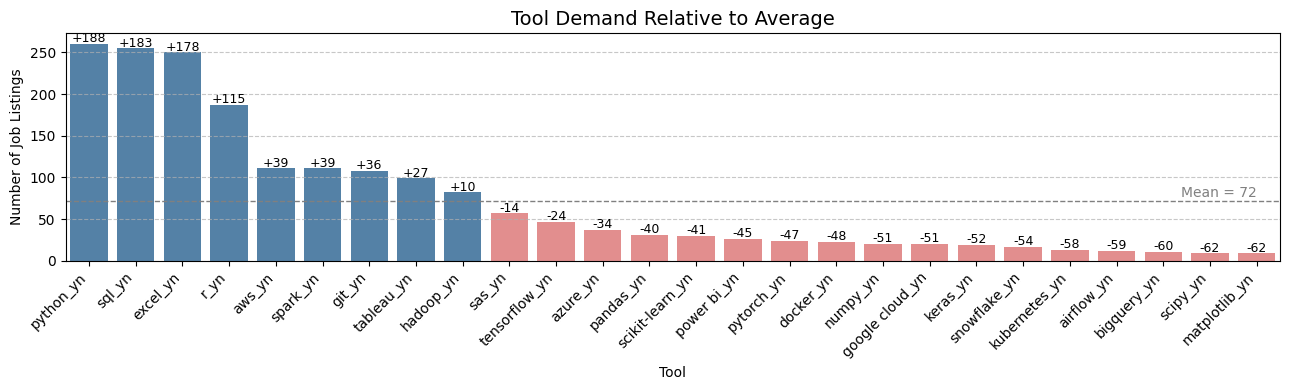

In [24]:
# Step 1: Calculate tool usage
tool_counts = df_analysis[[f"{tool}_yn" for tool in important_tools]].sum().sort_values(ascending=False).reset_index()
tool_counts.columns = ["Tool", "Count"]

# Step 2: Calculate average usage
avg_count = tool_counts["Count"].mean()
tool_counts["Deviation"] = tool_counts["Count"] - avg_count
tool_counts["Above Average"] = tool_counts["Deviation"] > 0

# Step 3: Color palette based on above/below
# Convert boolean Series to list of color names
palette = tool_counts["Above Average"].map({True: "steelblue", False: "lightcoral"}).tolist()

# Plot again with corrected palette
plt.figure(figsize=(13, 4))
sns.barplot(data=tool_counts, x="Tool", y="Count", palette=palette)

# Add deviation labels
for index, row in tool_counts.iterrows():
    label = f"+{int(row['Deviation'])}" if row["Deviation"] > 0 else f"{int(row['Deviation'])}"
    plt.text(index, row["Count"] + 2, label, ha="center", fontsize=9, color="black")

# Add mean line
plt.axhline(avg_count, linestyle="--", color="gray", linewidth=1)
plt.text(len(tool_counts) - 1, avg_count + 5, f"Mean = {avg_count:.0f}", ha="right", color="gray")

plt.title("Tool Demand Relative to Average", fontsize=14)
plt.xlabel("Tool")
plt.ylabel("Number of Job Listings")
plt.xticks(rotation=45, ha="right")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()



#### Tool Usage by Job Category

The heatmap below shows the proportion of job listings within each job category that mention specific tools or technologies. This allows us to identify which tools are most commonly expected for different roles in the data industry.

Values are normalized (in percentage) to highlight relative demand within each category.


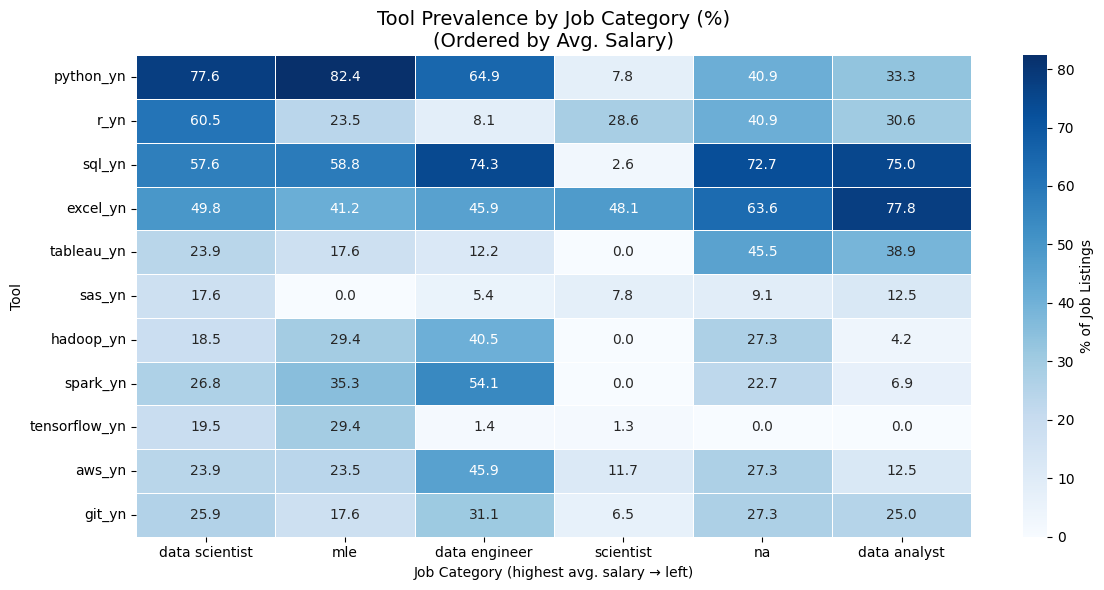

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt

# List of binary tool columns
tool_columns = [f"{tool}_yn" for tool in important_tools]

# 1. Compute average salary per job category
category_salary_mean = df_analysis.groupby("Job Category")["avg_salary"].mean().sort_values(ascending=False)

# 2. Compute tool usage by job category
tool_heatmap_data = df_analysis.groupby("Job Category")[tool_columns].mean().T * 100

# 3. Filter out tools with low total usage
tool_heatmap_data = tool_heatmap_data.loc[(df_analysis[tool_columns].sum() > 40).values]

# 4. Reorder columns based on salary ranking
tool_heatmap_data = tool_heatmap_data[category_salary_mean.index.intersection(tool_heatmap_data.columns)]

# 5. Plot
plt.figure(figsize=(12, 6))
sns.heatmap(
    tool_heatmap_data,
    annot=True,
    fmt=".1f",
    cmap="Blues",
    linewidths=0.5,
    cbar_kws={'label': '% of Job Listings'}
)
plt.title("Tool Prevalence by Job Category (%)\n(Ordered by Avg. Salary)", fontsize=14)
plt.xlabel("Job Category (highest avg. salary → left)")
plt.ylabel("Tool")
plt.tight_layout()
plt.show()


### e. Industry Reassignment

The `Industry` column contains many highly specific categories. To simplify the analysis and reduce dimensionality, we regrouped similar industries into broader, more interpretable categories.

For example:
- `"Biotech & Pharmaceuticals"` and `"Health Care Services & Hospitals"` → **Health & Pharmaceuticals**
- `"Insurance Carriers"` and `"Banks & Credit Unions"` → **Finance & Insurance**
- `"IT Services"` and `"Internet"` → **Technology**

Industries not matching predefined mappings were assigned to the **Other** category.

This new feature helps highlight trends across sectors while keeping the number of categories manageable.

In [26]:
# Refresh all_dfs before applying changes
all_dfs = [df_analysis, df_modeling_tree, df_modeling_linear]

# Apply reassign_industry
for i in range(len(all_dfs)):
    all_dfs[i]["Industry"] = all_dfs[i]["Industry"].apply(f.reassign_industry)

# Reassign updated versions
df_analysis, df_modeling_tree, df_modeling_linear = all_dfs


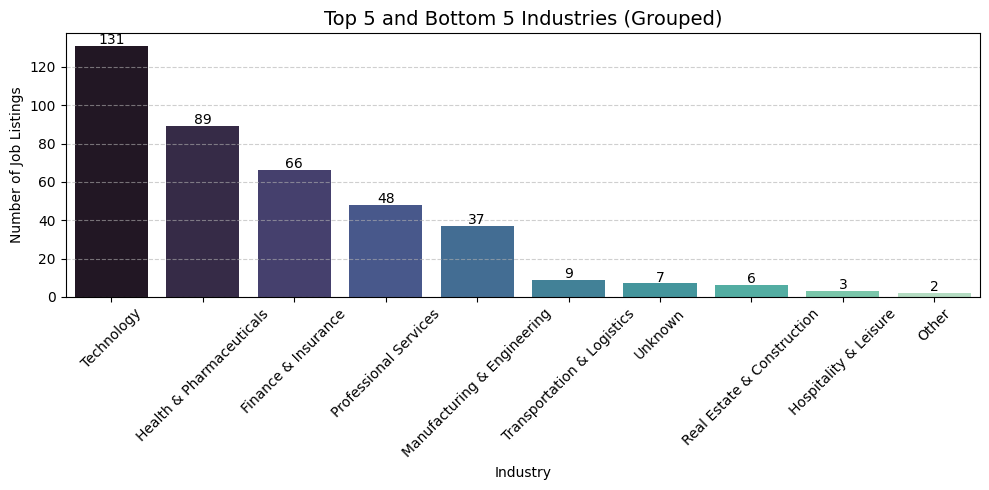

In [27]:
# Contar industrias
industry_counts = df_analysis["Industry"].value_counts()

# Combinar top 5 y bottom 5
combined_counts = pd.concat([
    industry_counts.head(5),
    industry_counts.tail(5)
]).reset_index()

combined_counts.columns = ["Industry", "Count"]

# Plot
plt.figure(figsize=(10, 5))
sns.barplot(data=combined_counts, x="Industry", y="Count", hue="Industry", palette="mako")

# Etiquetas numéricas
for i, row in combined_counts.iterrows():
    plt.text(i, row["Count"] + 1, row["Count"], ha='center')

plt.title("Top 5 and Bottom 5 Industries (Grouped)", fontsize=14)
plt.xlabel("Industry")
plt.ylabel("Number of Job Listings")
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()


#### Grouping Rare Industries

To avoid over-fragmentation, all industry categories with fewer than 5 job listings were grouped under the label `"Other"`.


In [28]:
# Contar industrias en df_analysis (o cualquier df base)
industry_counts = df_analysis["Industry"].value_counts()

# Definir umbral mínimo
min_threshold = 8

# Identificar industrias con baja frecuencia
low_count_industries = industry_counts[industry_counts < min_threshold].index

# Reemplazar con "Other" en todos los DataFrames
for i in range(len(all_dfs)):
    all_dfs[i]["Industry"] = all_dfs[i]["Industry"].apply(
        lambda x: "Other" if x in low_count_industries else x
    )

# Reasignar a los DataFrames originales
df_analysis, df_modeling_tree, df_modeling_linear = all_dfs


### f.  Sector Reassignment



Similar to the `Industry` field, the `Sector` column contains many highly specific categories. To simplify analysis, we grouped related sectors into broader categories using a predefined mapping.

This helps reduce noise in the data and ensures more meaningful comparisons across sectors.


In [29]:
# Obtener los conteos de cada sector
sector_counts = df_analysis['Sector'].value_counts()




In [30]:
# Paso 1: Agrupar sectores inconsistentes o poco frecuentes ANTES del mapeo
# Usamos df_analysis como base de referencia
sector_counts = df_analysis["Sector"].value_counts()
rare_sectors = sector_counts[sector_counts < 3].index

# Paso 2: Reemplazar '-1' y sectores poco frecuentes por 'other'
for i in range(len(all_dfs)):
    all_dfs[i]["Sector"] = all_dfs[i]["Sector"].apply(
        lambda x: "other" if x in rare_sectors or x == "-1" else x
    )

# Paso 3: Aplicar función de reasignación de sectores
for i in range(len(all_dfs)):
    all_dfs[i]["Sector"] = all_dfs[i]["Sector"].apply(f.reassign_sector)

# Paso 4: Volver a contar y eliminar sectores poco representados
sector_counts_final = df_analysis["Sector"].value_counts()
low_count_sectors = sector_counts_final[sector_counts_final < 6].index

for i in range(len(all_dfs)):
    all_dfs[i]["Sector"] = all_dfs[i]["Sector"].apply(
        lambda x: "Other" if x in low_count_sectors else x
    )

# Reasignar DataFrames
df_analysis, df_modeling_tree, df_modeling_linear = all_dfs



#### Sector Distribution (All Categories)

The bar chart below displays the number of job listings per sector, using all available categories after grouping and reassignment.


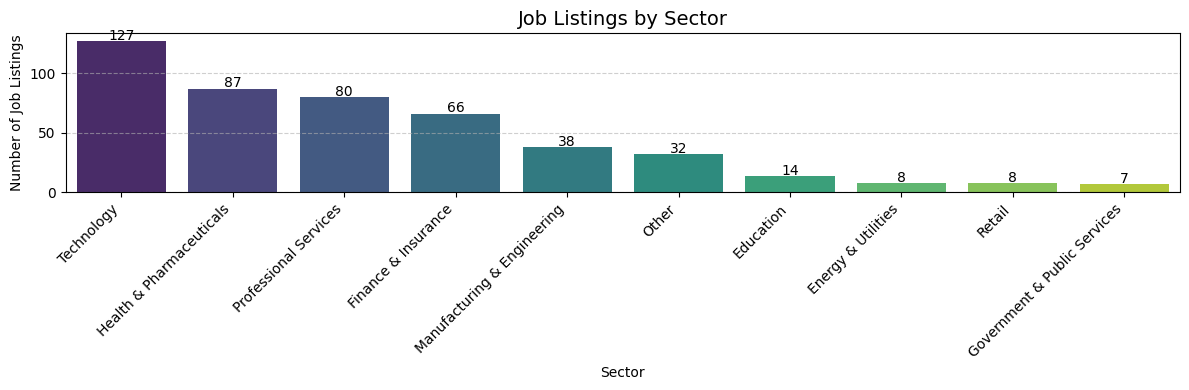

In [31]:
# Count all sector frequencies
sector_counts = df_analysis["Sector"].value_counts().reset_index()
sector_counts.columns = ["Sector", "Count"]

# Plot
plt.figure(figsize=(12, 4))
sns.barplot(data=sector_counts, x="Sector", y="Count",hue="Sector", palette="viridis")

# Add value labels
for i, row in sector_counts.iterrows():
    plt.text(i, row["Count"] + 1, row["Count"], ha='center', fontsize=10)

plt.title("Job Listings by Sector", fontsize=14)
plt.xlabel("Sector")
plt.ylabel("Number of Job Listings")
plt.xticks(rotation=45, ha="right")
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()


## 4. Final Cleaning and Dataset Preparation



In the final steps of our data cleaning process, we:

1. **Grouped rare ownership types**: Categories in `Type of ownership` with fewer than 3 listings were grouped under `"other"`.
2. **Optimized memory usage**: Converted all categorical columns with fewer than 10 unique values to the `"category"` data type.
3. **Cleaned company names**: Removed rating values (e.g., `\n3.8`) from the `Company Name` column, keeping only the company name itself.
4. **Removed unused columns**: Dropped columns that were no longer needed after feature engineering (e.g., raw text fields or intermediate steps).
5. **Exported the final dataset**: Saved the cleaned and transformed dataset for use in modeling and further analysis.


In [32]:
# Paso 1: Reasignar valores "-1" como "Unknown"
for i in range(len(all_dfs)):
    df = all_dfs[i]

    df["Size"] = df["Size"].apply(lambda x: "Unknown" if x == "-1" else x)
    df["Revenue"] = df["Revenue"].apply(lambda x: "Unknown" if x == "-1" else x)

    # Agrupar tipos de ownership raros
    ownership_counts = df_analysis["Type of ownership"].value_counts()
    df["Type of ownership"] = df["Type of ownership"].apply(
        lambda x: "other" if ownership_counts.get(x, 0) < 3 else x
    )

    # Limpiar nombre de empresa
    df["Company Name"] = df["Company Name"].apply(
        lambda x: x.split("\n")[0] if isinstance(x, str) else x
    )

    # Convertir columnas con pocas categorías a tipo 'category'
    for column in df.columns:
        if df[column].nunique() < 10:
            df[column] = df[column].astype("category")
        elif i == 0:
            # Solo imprimimos en df_analysis
            print(f"Column '{column}' has {df[column].nunique()} unique values ({df[column].dtype})")

    # Remover categorías no utilizadas en Size
    if "Size" in df.columns and pd.api.types.is_categorical_dtype(df["Size"]):
        df["Size"] = df["Size"].cat.remove_unused_categories()

    all_dfs[i] = df

# Paso 2: Eliminar columnas no necesarias en todos
columns_to_drop = [
    "Job Title", "Location", "Job Description", "min_salary", "max_salary", 
    "Salary Estimate", "Years of Experience", "Experience Extract", 
    "Experience Level", "company_txt", "Founded", "Headquarters", 
    "is_hourly", "Competitors"
]

for i in range(len(all_dfs)):
    all_dfs[i] = all_dfs[i].drop(columns=[col for col in columns_to_drop if col in all_dfs[i].columns])

# Paso 3: Reasignar DataFrames finales
df_analysis, df_modeling_tree, df_modeling_linear = all_dfs


Column 'Job Title' has 264 unique values (object)
Column 'Salary Estimate' has 416 unique values (object)
Column 'Job Description' has 463 unique values (object)
Column 'Rating' has 31 unique values (float64)
Column 'Company Name' has 343 unique values (object)
Column 'Location' has 200 unique values (object)
Column 'Headquarters' has 198 unique values (object)
Column 'Founded' has 102 unique values (int64)
Column 'Industry' has 12 unique values (object)
Column 'Sector' has 10 unique values (object)
Column 'Revenue' has 14 unique values (object)
Column 'Competitors' has 128 unique values (object)
Column 'Years of Experience' has 21 unique values (float64)
Column 'Experience Extract' has 40 unique values (object)
Column 'min_salary' has 114 unique values (int64)
Column 'max_salary' has 160 unique values (int64)
Column 'avg_salary' has 219 unique values (float64)
Column 'company_txt' has 343 unique values (object)
Column 'job_state' has 38 unique values (object)
Column 'age' has 102 uniq

C:\Users\frano\AppData\Local\Temp\ipykernel_12176\756107940.py:28: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if "Size" in df.columns and pd.api.types.is_categorical_dtype(df["Size"]):
C:\Users\frano\AppData\Local\Temp\ipykernel_12176\756107940.py:28: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if "Size" in df.columns and pd.api.types.is_categorical_dtype(df["Size"]):
C:\Users\frano\AppData\Local\Temp\ipykernel_12176\756107940.py:28: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if "Size" in df.columns and pd.api.types.is_categorical_dtype(df["Size"]):


In [33]:
# Nombres de archivo para cada DataFrame
file_names = [
    "df_analysis_cleaned.csv",
    "df_modeling_tree_cleaned.csv",
    "df_modeling_linear_cleaned.csv"
]

# Exportar cada DataFrame en la carpeta ../Data/
exported_files = []

for df, name in zip([df_analysis, df_modeling_tree, df_modeling_linear], file_names):
    full_path = f"../Data/{name}"
    df.to_csv(full_path, index=False)
    exported_files.append(full_path)

print("✅ Exported files:", exported_files)


✅ Exported files: ['../Data/df_analysis_cleaned.csv', '../Data/df_modeling_tree_cleaned.csv', '../Data/df_modeling_linear_cleaned.csv']
